<a href="https://colab.research.google.com/github/henningheyen/ICLR-Submission/blob/main/Colab_Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation

In [ ]:
!git clone https://github.com/henningheyen/Scalability-Of-LLM-Posthoc-Explanations.git

In [ ]:
%cd Scalability-Of-LLM-Posthoc-Explanations

In [ ]:
# Installing Dependencies
!pip install lime
!pip install transformers
!pip install sentencepiece
!pip install datasets

In [4]:
from datasets import load_dataset

def make_test_set_cose(size, seed=42): # 1221 max size for mnli

  dataset = load_dataset("cos_e", 'v1.11')['validation']

  random.seed(seed)
  random_indices = random.sample(list(range(len(dataset['question']))), size)

  test_set = dataset[random_indices]
  candidate_labels_list = test_set['choices']

  true_labels = [test_set['choices'][i].index(test_set['answer'][i]) for i in range(size)]

  return {
      'question': test_set['question'],
      'choices': test_set['choices'],
      'answer': test_set['answer'],
      'true_labels': true_labels,
      'extractive_explanation': test_set['extractive_explanation'],
      'candidate_labels_list': candidate_labels_list,
  }



In [5]:
from datasets import load_dataset

def make_test_set_mnli(size, seed=42): # 9815 max size for mnli

  dataset = load_dataset("multi_nli")['validation_matched']
  new_labels = [2 if label == 1 else 1 if label == 0 else 0 for label in dataset['label']] # original: [entailment:0,neutral:1,contradiction:2] deberta: [contradiction:0,entailment:1,neutral:2]

  # Randomly sample the desired number of indices
  random.seed(seed)
  random_indices = random.sample(list(range(len(dataset['label']))), size)

  test_set = [(dataset['premise'][i], dataset['hypothesis'][i]) for i in random_indices]
  print('check3')
  test_labels = [new_labels[i] for i in random_indices]
  test_labels_text = ['contradiction' if test_labels[i]==0 else 'entailment' if test_labels[i]==1 else 'neutral' for i in range(len(test_labels))]

  return {
      'sentence_pairs': test_set,
      'test_labels': test_labels,
      'test_labels_text': test_labels_text
      }



In [6]:
# Preprocessing e-SNLI
import pandas as pd
import random

def make_test_set_esnli(size, path='data/esnli_dev.csv', seed=42): # 9842 max size for mnli

    #loading data
    df = pd.read_csv(path)
    df = df[['gold_label', 'Sentence1', 'Sentence2', 'Sentence1_marked_1', 'Sentence2_marked_1', 'Sentence1_Highlighted_1', 'Sentence2_Highlighted_1']]

    dataset = df.to_dict(orient='list')

    random.seed(seed)
    random_indices = random.sample(list(range(df.shape[0])), size)

    sentence_pairs = [(dataset['Sentence1'][i], dataset['Sentence2'][i]) for i in random_indices]
    test_labels_text = [dataset['gold_label'][i] for i in random_indices]
    label_to_num = {'contradiction': 0, 'entailment': 1, 'neutral': 2}
    test_labels = [label_to_num[label] for label in test_labels_text]
    sentence1_marked = [dataset['Sentence1_marked_1'][i] for i in random_indices]
    sentence2_marked = [dataset['Sentence2_marked_1'][i] for i in random_indices]
    sentence1_highlights = [dataset['Sentence1_Highlighted_1'][i] for i in random_indices]
    sentence2_highlights = [dataset['Sentence2_Highlighted_1'][i] for i in random_indices]


    return {
        'sentence_pairs': sentence_pairs,
        'test_labels': test_labels,
        'test_labels_text': test_labels_text,
        'sentence1_marked': sentence1_marked,
        'sentence2_marked': sentence2_marked,
        'sentence1_highlights': sentence1_highlights,
        'sentence2_highlights': sentence2_highlights,
        }


In [7]:
esnli_size = 9842
mnli_size = 9815
cose_size = 1221

num_batches = 100

In [ ]:
#importing dataset
dataset_esnli = make_test_set_esnli(size=esnli_size) # 9842 is dev size esnli
dataset_mnli = make_test_set_mnli(size=mnli_size) # 9815 is dev size mnli
dataset_cose = make_test_set_cose(size=cose_size) # 1221 is dev size cose

# Quick EDA

In [12]:
dataset_cose.keys()

dict_keys(['question', 'choices', 'answer', 'true_labels', 'extractive_explanation', 'candidate_labels_list'])

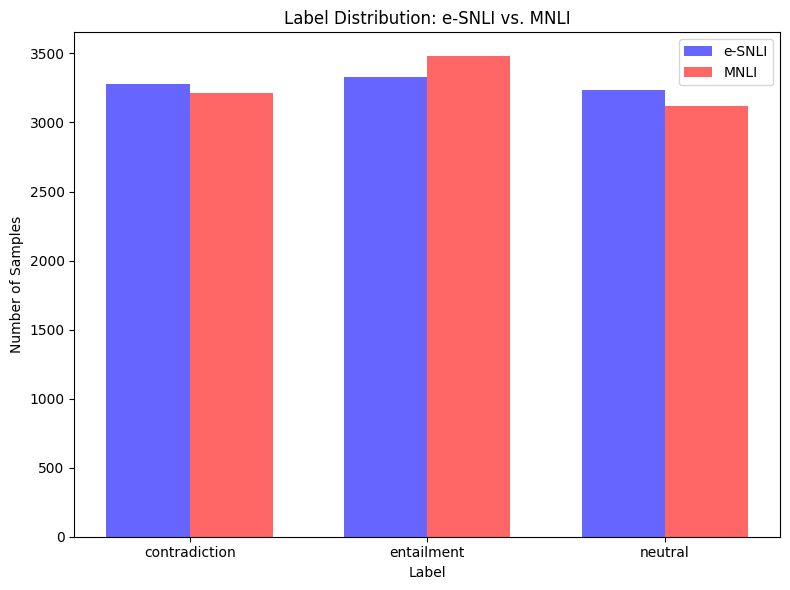

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Extract label distribution from both datasets:
unique_labels_esnli, counts_esnli = np.unique(dataset_esnli['test_labels_text'], return_counts=True)
unique_labels_mnli, counts_mnli = np.unique(dataset_mnli['test_labels_text'], return_counts=True)

bar_width = 0.35
index = np.arange(len(unique_labels_esnli))

plt.figure(figsize=(8, 6))
bar1 = plt.bar(index, counts_esnli, bar_width, color='b', alpha=0.6, label='e-SNLI')
bar2 = plt.bar(index + bar_width, counts_mnli, bar_width, color='r', alpha=0.6, label='MNLI')

plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Label Distribution: e-SNLI vs. MNLI')
plt.xticks(index + bar_width / 2, unique_labels_esnli)  # position the labels in the middle of the grouped bars
plt.legend()

plt.tight_layout()
plt.show()


# Natural Langugae Inference

## e-SNLI

In [14]:
from model import ModelNLI
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [17]:
xsmall = ModelNLI(model_name='cross-encoder/nli-deberta-v3-xsmall')
small = ModelNLI(model_name='cross-encoder/nli-deberta-v3-small')
base = ModelNLI(model_name='cross-encoder/nli-deberta-v3-base')
large = ModelNLI(model_name='cross-encoder/nli-deberta-v3-large')

models = [
    xsmall,
    small,
    base,
    large
]

model_names = [
    'xsmall',
    'small',
    'base',
    'large'
]

In [16]:
%%time
deberta_xsmall_pred_esnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = esnli_size/num_batches
  deberta_xsmall_pred_batch = xsmall.get_predictions(dataset_esnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_xsmall_pred_esnli += deberta_xsmall_pred_batch



CPU times: user 7min 9s, sys: 3min 26s, total: 10min 36s
Wall time: 10min 44s


In [ ]:
%%time
deberta_small_pred_esnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = esnli_size/num_batches
  deberta_small_pred_batch = small.get_predictions(dataset_esnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_small_pred_esnli += deberta_small_pred_batch



CPU times: user 12min 1s, sys: 8.04 s, total: 12min 9s
Wall time: 3min 2s


In [ ]:
%%time
deberta_base_pred_esnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = esnli_size/num_batches
  deberta_base_pred_batch = base.get_predictions(dataset_esnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_base_pred_esnli += deberta_base_pred_batch



CPU times: user 24min 41s, sys: 22 s, total: 25min 3s
Wall time: 6min 16s


In [ ]:
%%time
deberta_large_pred_esnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = esnli_size/num_batches
  deberta_large_pred_batch = large.get_predictions(dataset_esnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_large_pred_esnli += deberta_large_pred_batch



CPU times: user 1h 15min 50s, sys: 4min 45s, total: 1h 20min 36s
Wall time: 20min 8s


In [18]:
predictions_esnli = [
    deberta_xsmall_pred_esnli,
    deberta_small_pred_esnli,
    deberta_base_pred_esnli,
    deberta_large_pred_esnli
    ]

In [ ]:
for i, pred in enumerate(predictions_esnli):
    print(f'{model_names[i]}:', accuracy_score(dataset_esnli['test_labels'], pred))


e-SNLI full dev set (9842) evaluation (accuracy):
- xsmall: 0.9203413940256046
- small: 0.9219670798618167
- base: 0.9314163787847999
- large: 0.9321276163381427

## MNLI

In [ ]:
%%time
deberta_xsmall_pred_mnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = mnli_size/num_batches
  deberta_xsmall_pred_batch = xsmall.get_predictions(dataset_mnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_xsmall_pred_mnli += deberta_xsmall_pred_batch


In [ ]:
%%time
deberta_small_pred_mnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = mnli_size/num_batches
  deberta_small_pred_batch = small.get_predictions(dataset_mnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_small_pred_mnli += deberta_small_pred_batch


In [ ]:
%%time
deberta_base_pred_mnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = mnli_size/num_batches
  deberta_base_pred_batch = base.get_predictions(dataset_mnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_base_pred_mnli += deberta_base_pred_batch


In [ ]:
%%time
deberta_large_pred_mnli = []

# As RAM is limited need to calculate in batches
for i in range(num_batches):
  batch_size = mnli_size/num_batches
  deberta_large_pred_batch = large.get_predictions(dataset_mnli['sentence_pairs'][round(i*batch_size):round((i+1)*batch_size)])
  deberta_large_pred_mnli += deberta_large_pred_batch


In [ ]:
predictions_mnli = [
    deberta_xsmall_pred_mnli,
    deberta_small_pred_mnli,
    deberta_base_pred_mnli,
    deberta_large_pred_mnli
    ]

In [ ]:
for i, pred in enumerate(predictions_mnli):
    print(f'{model_names[i]}:', accuracy_score(dataset_mnli['test_labels'], pred))


MNLI full dev set (9815) evaluation (accuracy):
- xsmall: 0.878349465104432
- small: 0.8779419256240448
- base: 0.8999490575649516
- large: 0.9019867549668874

# Zero Shot Classification

In [ ]:
from model import ModelZSC


In [ ]:
xsmall = ModelZSC('cross-encoder/nli-deberta-v3-xsmall')
small = ModelZSC('cross-encoder/nli-deberta-v3-small')
base = ModelZSC('cross-encoder/nli-deberta-v3-base')
large = ModelZSC('cross-encoder/nli-deberta-v3-large')

models = [
     xsmall,
     small,
     base,
     large,
 ]

model_names = [
     'xsmall',
     'small',
     'base',
     'large',
 ]

In [ ]:
%%time
deberta_xsmall_results_cose = xsmall.get_results(dataset_cose['question'], candidate_labels_list=dataset_cose['candidate_labels_list'])

CPU times: user 20min 12s, sys: 2.8 s, total: 20min 15s
Wall time: 5min 3s


In [ ]:
%%time
deberta_small_results_cose = small.get_results(dataset_cose['question'], candidate_labels_list=dataset_cose['candidate_labels_list'])

CPU times: user 26min 34s, sys: 2.27 s, total: 26min 36s
Wall time: 6min 38s


In [ ]:
%%time
deberta_base_results_cose = base.get_results(dataset_cose['question'], candidate_labels_list=dataset_cose['candidate_labels_list'])

CPU times: user 52min 23s, sys: 4.41 s, total: 52min 28s
Wall time: 13min 6s


In [ ]:
%%time
deberta_large_results_cose = large.get_results(dataset_cose['question'], candidate_labels_list=dataset_cose['candidate_labels_list'])

CPU times: user 2h 52min 40s, sys: 36.9 s, total: 2h 53min 17s
Wall time: 43min 15s


In [ ]:
results_cose = [
    deberta_xsmall_results_cose,
    deberta_small_results_cose,
    deberta_base_results_cose,
    deberta_large_results_cose
    ]

In [ ]:
predictions_cose = [model.get_predictions(result, dataset_cose['candidate_labels_list']) for (model, result) in zip(models,results_cose)]


In [ ]:
for i, prediction in enumerate(predictions_cose):
    print(f'accuracy ({model_names[i]}): ', accuracy_score(prediction, dataset_cose['true_labels']))


CoS-e full dev set (1221) evaluation (accuracy):
- xsmall: 0.3308763308763309
- small: 0.3357903357903358
- base: 0.35872235872235875
- large: 0.3775593775593776


##Logging the results

In [ ]:
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

results = {
    'esnli': {
        'true': dataset_esnli['test_labels'],
          'xsmall': {
              'pred': predictions_esnli[0],
              'accuracy': accuracy_score(dataset_esnli['test_labels'], predictions_esnli[0]),
              'percision': precision_score(dataset_esnli['test_labels'], predictions_esnli[0], average='macro'),
              'recall': recall_score(dataset_esnli['test_labels'], predictions_esnli[0], average='macro'),
              'f1': f1_score(dataset_esnli['test_labels'], predictions_esnli[0], average='macro'),
          },
          'small': {
              'pred': predictions_esnli[1],
              'accuracy': accuracy_score(dataset_esnli['test_labels'], predictions_esnli[1]),
              'percision': precision_score(dataset_esnli['test_labels'], predictions_esnli[1], average='macro'),
              'recall': recall_score(dataset_esnli['test_labels'], predictions_esnli[1], average='macro'),
              'f1': f1_score(dataset_esnli['test_labels'], predictions_esnli[1], average='macro'),
          },
          'base': {
              'pred': predictions_esnli[2],
              'accuracy': accuracy_score(dataset_esnli['test_labels'], predictions_esnli[2]),
              'percision': precision_score(dataset_esnli['test_labels'], predictions_esnli[2], average='macro'),
              'recall': recall_score(dataset_esnli['test_labels'], predictions_esnli[2], average='macro'),
              'f1': f1_score(dataset_esnli['test_labels'], predictions_esnli[2], average='macro'),
          },
          'large': {
              'pred': predictions_esnli[3],
              'accuracy': accuracy_score(dataset_esnli['test_labels'], predictions_esnli[3]),
              'percision': precision_score(dataset_esnli['test_labels'], predictions_esnli[3], average='macro'),
              'recall': recall_score(dataset_esnli['test_labels'], predictions_esnli[3], average='macro'),
              'f1': f1_score(dataset_esnli['test_labels'], predictions_esnli[3], average='macro'),
          },
    },
        'mnli': {
          'true': dataset_mnli['test_labels'],
          'xsmall': {
              'pred': predictions_mnli[0],
              'accuracy': accuracy_score(dataset_mnli['test_labels'], predictions_mnli[0]),
              'percision': precision_score(dataset_mnli['test_labels'], predictions_mnli[0], average='macro'),
              'recall': recall_score(dataset_mnli['test_labels'], predictions_mnli[0], average='macro'),
              'f1': f1_score(dataset_mnli['test_labels'], predictions_mnli[0], average='macro'),
          },
          'small': {
              'pred': predictions_mnli[1],
              'accuracy': accuracy_score(dataset_mnli['test_labels'], predictions_mnli[1]),
              'percision': precision_score(dataset_mnli['test_labels'], predictions_mnli[1], average='macro'),
              'recall': recall_score(dataset_mnli['test_labels'], predictions_mnli[1], average='macro'),
              'f1': f1_score(dataset_mnli['test_labels'], predictions_mnli[1], average='macro'),
          },
          'base': {
              'pred': predictions_mnli[2],
              'accuracy': accuracy_score(dataset_mnli['test_labels'], predictions_mnli[2]),
              'percision': precision_score(dataset_mnli['test_labels'], predictions_mnli[2], average='macro'),
              'recall': recall_score(dataset_mnli['test_labels'], predictions_mnli[2], average='macro'),
              'f1': f1_score(dataset_mnli['test_labels'], predictions_mnli[2], average='macro'),
          },
          'large': {
              'pred': predictions_mnli[3],
              'accuracy': accuracy_score(dataset_mnli['test_labels'], predictions_mnli[3]),
              'percision': precision_score(dataset_mnli['test_labels'], predictions_mnli[3], average='macro'),
              'recall': recall_score(dataset_mnli['test_labels'], predictions_mnli[3], average='macro'),
              'f1': f1_score(dataset_mnli['test_labels'], predictions_mnli[3], average='macro'),
          },
    },
        'cose': {
          'true': dataset_cose['true_labels'],
          'xsmall': {
              'pred': predictions_cose[0],
              'accuracy': accuracy_score(dataset_cose['true_labels'], predictions_cose[0]),
          },
          'small': {
              'pred': predictions_cose[1],
              'accuracy': accuracy_score(dataset_cose['true_labels'], predictions_cose[1]),
          },
          'base': {
              'pred': predictions_cose[2],
              'accuracy': accuracy_score(dataset_cose['true_labels'], predictions_cose[2]),
          },
          'large': {
              'pred': predictions_cose[3],
              'accuracy': accuracy_score(dataset_cose['true_labels'], predictions_cose[3]),
          },
    },
}

# results are of type np.int64 which is not serializable so we convert it to int()
def convert_numpy_int(item):
    if isinstance(item, np.int64):
        return int(item)
    elif isinstance(item, list):
        return [convert_numpy_int(sub_item) for sub_item in item]
    elif isinstance(item, dict):
        return {key: convert_numpy_int(value) for key, value in item.items()}
    else:
        return item

results_converted = convert_numpy_int(results)

# Specify the file name
output_file = 'results.json'

# Save the dictionary as a JSON file
with open(output_file, 'w') as json_file:
    json.dump(results_converted, json_file, indent=4)

# Visualisations

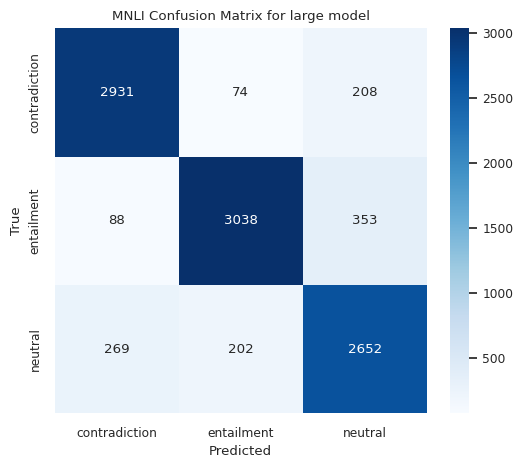

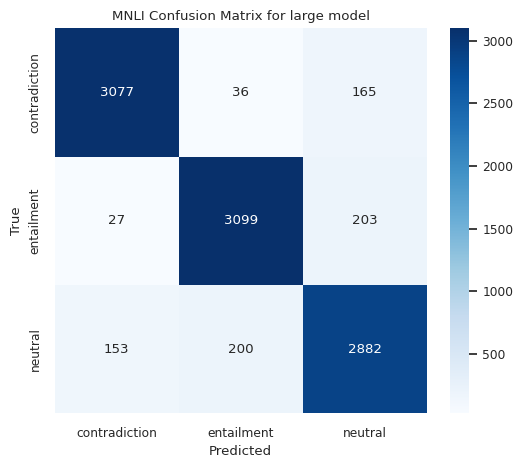

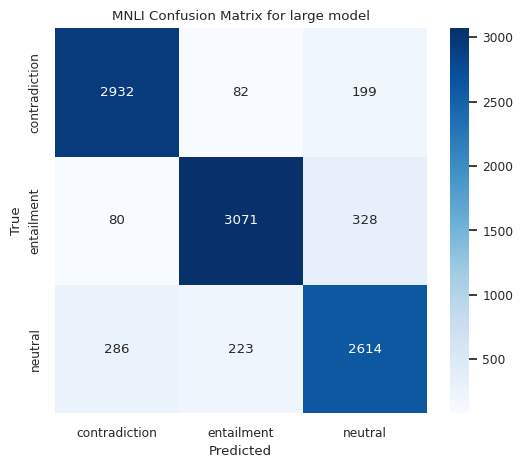

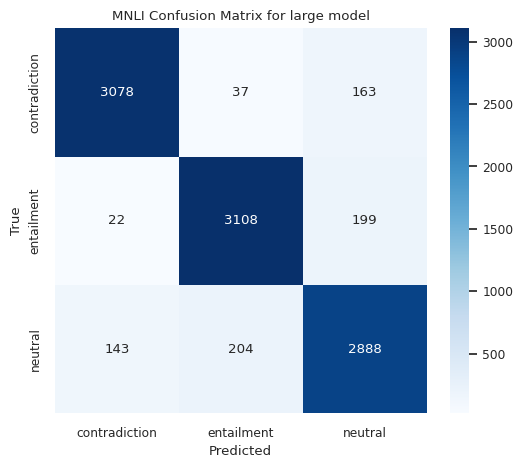

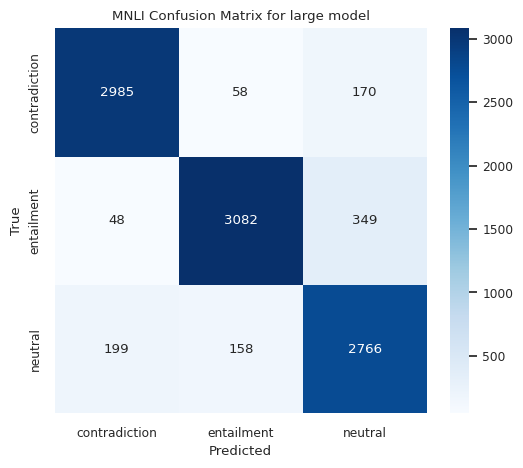

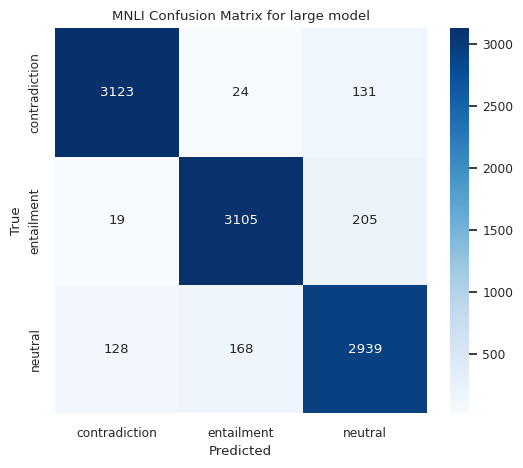

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Labels for the classes
class_names = ['contradiction', 'entailment', 'neutral']

# Calculate the confusion matrix

for i in range(3):

  for dataset, prediction in zip([dataset_mnli, dataset_esnli],[predictions_mnli, predictions_esnli]):

    y_pred = prediction[i]
    y_true = dataset['test_labels']

    conf_matrix = confusion_matrix(y_true, y_pred)

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.set(font_scale=0.8)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('MNLI Confusion Matrix for large model')
    plt.show()


